# グラフオートエンコーダで埋め込みを求める
テストデータ(MUTAG)を使用

## データの前処理

In [272]:
# データの読み込み
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import TUDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.ToDevice(device),
])

dataset = TUDataset(root='data/TUDataset', name='MUTAG', transform=transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


In [168]:
from torch.utils.data.dataset import random_split
from torch_geometric.datasets import TUDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.ToDevice(device)

# REDDIT-BINARY データセットをロード
dataset = TUDataset(root='data/TUDataset', name='REDDIT-BINARY', transform=transform)

subset_size = 500
dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])

# REDDIT-BINARY データセットの情報を表示
print(f'REDDIT-BINARY: {len(dataset)} graphs')

REDDIT-BINARY: 500 graphs


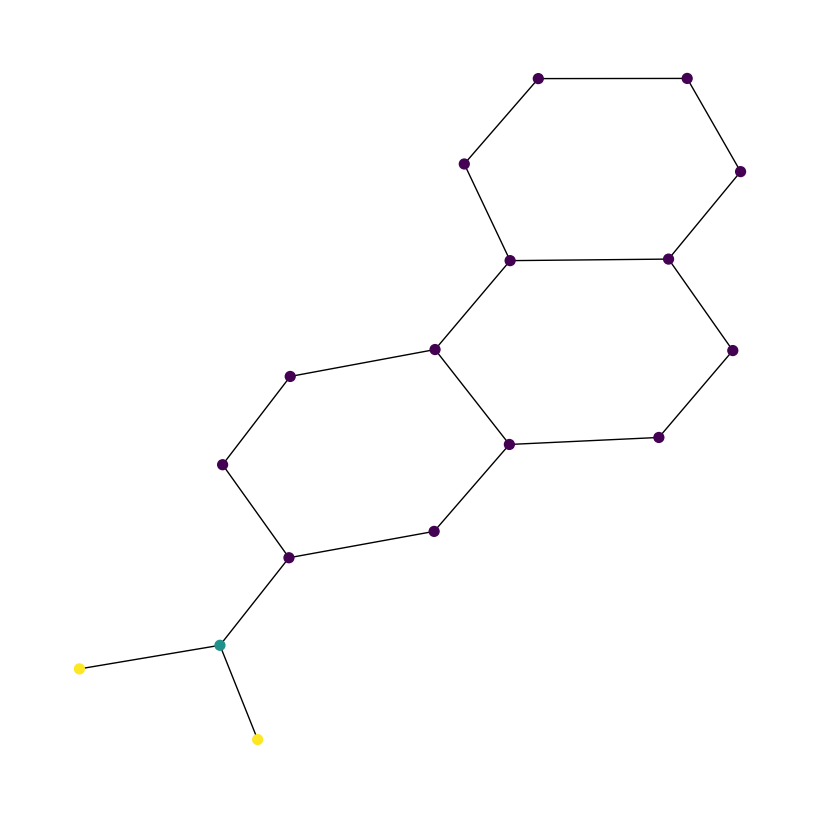

In [250]:
# グラフの可視化
import networkx as nx
import numpy as np
import torch_geometric
import matplotlib.pyplot as plt

data = dataset[0]
G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

# ノードの特徴量（one-hotベクトル）
node_features = data.x.cpu().numpy()

# 各ノードの色をone-hotベクトルの最大値に基づいて設定
node_colors = np.argmax(node_features, axis=1)

cmap = plt.get_cmap('viridis', 7)  # 7次元に対応するカラーマップ

# グラフ描画
plt.figure(figsize=(8,8)) # 適切なサイズで
nx.draw(G, pos=nx.nx_pydot.graphviz_layout(G), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9,
		node_color=node_colors, cmap=cmap)
plt.show()

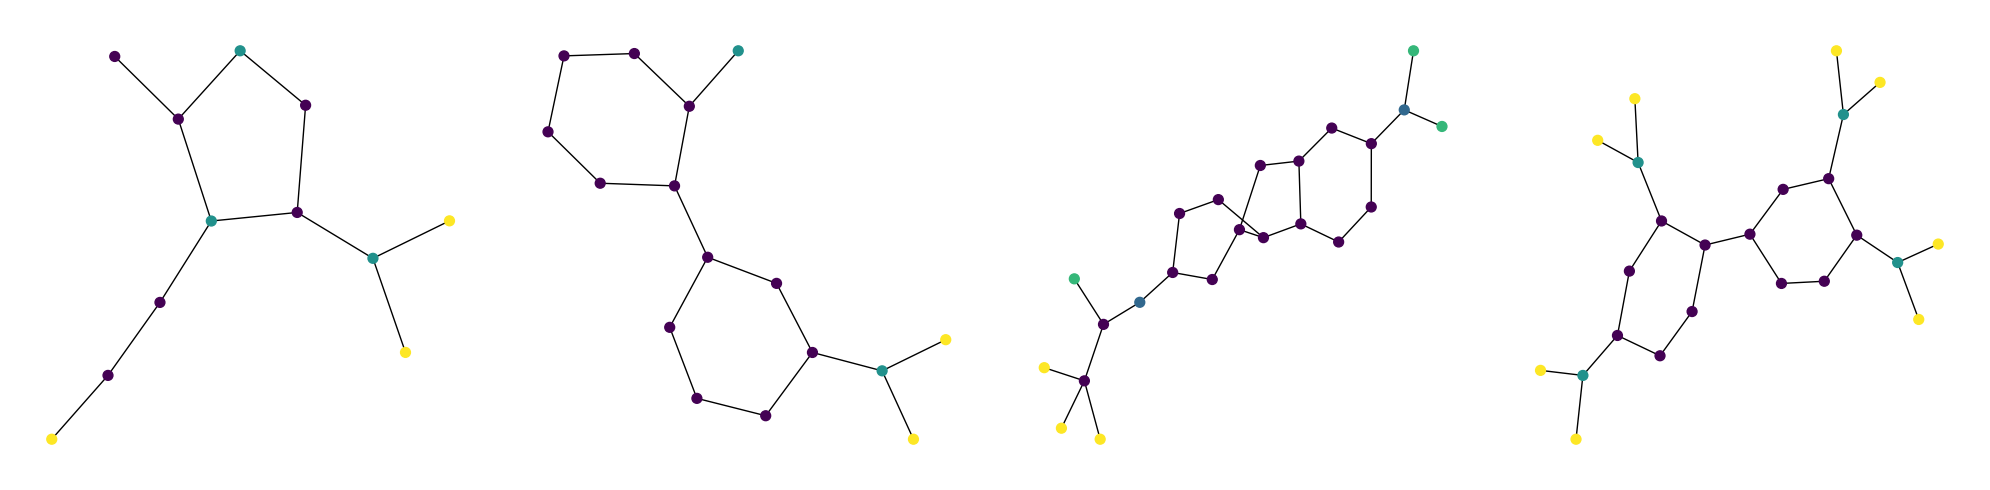

In [320]:
# 複数個描画してどんな感じのグラフがあるか見る
import random

# データセットからランダムに選択
count = 4
random_indices = random.sample(range(len(dataset)), count)

# 描画用のサブプロット作成
fig, axs = plt.subplots(1, count, figsize=(20, 5))  # 1行count列でcount個のグラフを表示

for i, idx in enumerate(random_indices):
    data = dataset[idx]
    G = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)

    # ノードの特徴量（one-hotベクトル）
    node_features = data.x.cpu().numpy()

    # 各ノードの色をone-hotベクトルの最大値に基づいて設定
    node_colors = np.argmax(node_features, axis=1)

    cmap = plt.get_cmap('viridis', 7)  # 7次元に対応するカラーマップ

    # グラフ描画
    nx.draw(G, pos=nx.nx_pydot.graphviz_layout(G), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9,
            node_color=node_colors, cmap=cmap, ax=axs[i])  # axを指定してサブプロットに描画
    axs[i].set_title(f'Graph {i+1} (Index: {idx})')

# 全体のレイアウト調整
plt.tight_layout()
plt.show()

In [215]:
# 構造情報だけ使いたい場合
# 属性に適当な値を設定する

import torch

def add_dummy_node_features(dataset):
    new_dataset = []
    for data in dataset:
        num_nodes = data.num_nodes  # 各グラフのノード数を取得

        # 属性を1に
        data.x = torch.ones(num_nodes, 1).to(device)
        new_dataset.append(data)
    return new_dataset

# 適当な属性（ワンホットベクトル）を追加
dataset = add_dummy_node_features(dataset)

# 確認
for i, data in enumerate(dataset[:5]):  # 最初の5グラフを確認
    print(f'Graph {i} node features:\n', data.x)

Graph 0 node features:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
Graph 1 node features:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
Graph 2 node features:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
Graph 3 node features:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1

In [273]:
# ミニバッチ処理
from torch_geometric.loader import DataLoader

transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False)

train_data_list = []
test_data_list = []

# データセットの各グラフに対してtransformを適用
for graph_data in dataset:
    train_data, val_data, test_data = transform(graph_data)
    train_data_list.append(train_data)
    test_data_list.append(test_data)

# DataLoaderの作成（複数のグラフを含むバッチ処理）
train_loader = DataLoader(train_data_list, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=64)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2226], x=[1123, 7], edge_attr=[2226, 4], y=[64], pos_edge_label=[1113], pos_edge_label_index=[2, 1113], batch=[1123], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2292], x=[1158, 7], edge_attr=[2292, 4], y=[64], pos_edge_label=[1146], pos_edge_label_index=[2, 1146], batch=[1158], ptr=[65])

Step 3:
Number of graphs in the current batch: 60
DataBatch(edge_index=[2, 2164], x=[1090, 7], edge_attr=[2164, 4], y=[60], pos_edge_label=[1082], pos_edge_label_index=[2, 1082], batch=[1090], ptr=[61])



## モデルの作成 & 訓練

In [287]:
# モデルの作成
import torch
from torch_geometric.nn import GCNConv, GAE
    
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# in_channels: 特徴量の次元数
# out_channels: 埋め込みの次元数
# in_channels, out_channels = dataset.num_features, 2
in_channels, out_channels = 7, 16
model = GAE(Encoder(in_channels, out_channels))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)

GAE(
  (encoder): Encoder(
    (conv1): GCNConv(7, 32)
    (conv2): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


### 訓練

In [277]:
import torch_geometric.transforms as T

def train():
    model.train()
    optimizer.zero_grad()

    for batch_data in train_loader:  # バッチごとに複数のグラフが渡される
        z = model.encode(batch_data.x, batch_data.edge_index)
        loss = model.recon_loss(z, batch_data.pos_edge_label_index)

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.


@torch.no_grad()
def test(loader):
    model.eval()
    total_auc = 0
    total_ap = 0
    total_samples = 0
    for batch_data in loader:  # バッチごとに複数のグラフが渡される
        z = model.encode(batch_data.x, batch_data.edge_index)
        
        auc, ap = model.test(z, batch_data.pos_edge_label_index, batch_data.neg_edge_label_index)
        
        # 重み付けを考慮して合計を更新
        total_auc += auc * batch_data.num_graphs
        total_ap += ap * batch_data.num_graphs
        total_samples += batch_data.num_graphs
    
    # 重み付け平均を返す
    return total_auc / total_samples, total_ap / total_samples

Epoch: 001, AUC: 0.5776, AP: 0.5115
Epoch: 002, AUC: 0.5923, AP: 0.5261
Epoch: 003, AUC: 0.6235, AP: 0.5917
Epoch: 004, AUC: 0.6205, AP: 0.5921
Epoch: 005, AUC: 0.6160, AP: 0.5892
Epoch: 006, AUC: 0.6192, AP: 0.5893
Epoch: 007, AUC: 0.6249, AP: 0.5828
Epoch: 008, AUC: 0.6227, AP: 0.5823
Epoch: 009, AUC: 0.6140, AP: 0.5632
Epoch: 010, AUC: 0.6113, AP: 0.5632
Epoch: 011, AUC: 0.6091, AP: 0.5664
Epoch: 012, AUC: 0.5884, AP: 0.5282
Epoch: 013, AUC: 0.5800, AP: 0.5209
Epoch: 014, AUC: 0.5676, AP: 0.5149
Epoch: 015, AUC: 0.5411, AP: 0.5007
Epoch: 016, AUC: 0.5394, AP: 0.5038
Epoch: 017, AUC: 0.5229, AP: 0.4965
Epoch: 018, AUC: 0.5296, AP: 0.5001
Epoch: 019, AUC: 0.5434, AP: 0.5106
Epoch: 020, AUC: 0.5176, AP: 0.4954
Epoch: 021, AUC: 0.5314, AP: 0.5079
Epoch: 022, AUC: 0.5304, AP: 0.5099
Epoch: 023, AUC: 0.4964, AP: 0.4864
Epoch: 024, AUC: 0.5251, AP: 0.5078
Epoch: 025, AUC: 0.5257, AP: 0.5078
Epoch: 026, AUC: 0.5028, AP: 0.4953
Epoch: 027, AUC: 0.5092, AP: 0.5022
Epoch: 028, AUC: 0.5176, AP:

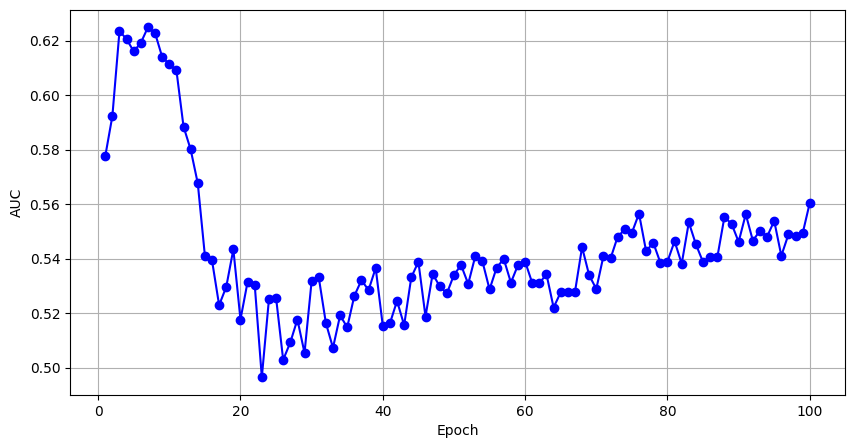

In [288]:
# 学習
import matplotlib.pyplot as plt

epochs = 100
auc_history = []
best_auc = 0
for epoch in range(1, epochs + 1):
    loss = train()
    mean_auc, mean_ap = test(test_loader)
    auc_history.append(mean_auc)
    print(f'Epoch: {epoch:03d}, AUC: {mean_auc:.4f}, AP: {mean_ap:.4f}')

    # 一番いいモデルを保存する
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_model_state = model.state_dict()  # モデルのパラメータを保存

# AUCの変化の可視化
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), auc_history, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)
plt.show()

## 検証

In [289]:
# 一番いいモデルをロード
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [290]:
# 各グラフの埋め込みを求める
from torch_geometric.data.batch import Batch
from torch_geometric.nn import global_mean_pool, global_add_pool

batch = Batch.from_data_list(dataset)

# ノード埋め込みの取得
z = model.encode(batch.x, batch.edge_index)


# グラフごとの埋め込みをプーリングして取得
graph_embeddings = global_add_pool(z, batch.batch)
# graph_embeddings = global_mean_pool(batch.x, batch.batch)

with torch.no_grad():
	graph_embeddings = graph_embeddings.cpu().numpy()

graph_embeddings.shape

(188, 16)

### 埋め込みの可視化

In [204]:
# 描画する関数
def plot_points(z, node_labels=None):
    """
        z: 埋め込み
        node_labels: G.nodesを指定すればOK 何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))
    plt.scatter(z[:, 0], z[:, 1], s=70, color='b', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")

    plt.axis('off')
    plt.show()

In [205]:
# 描画する関数(クラスも可視化)
def plot_points(z, y, node_labels=None):
    """
    z: 埋め込み (2次元のテンソル or 配列)
    y: クラスラベル (各点のクラス、同じ長さの配列)
    node_labels: G.nodesを指定すればOK。何も指定しなければラベルを表示しない
    """

    plt.figure(figsize=(9, 9))

    # クラスラベルに基づいて色を変更
    plt.scatter(z[:, 0], z[:, 1], s=70, c=y, cmap='viridis', alpha=0.6)

    # ノードのラベルを表示
    if node_labels:
        for i, label in enumerate(node_labels):
            plt.text(z[i, 0], z[i, 1] + 0.08, label, fontsize=9, ha='center', va='center', fontname="MS Gothic")

    plt.axis('off')
    plt.show()

In [ ]:
# 2次元の埋め込み
plot_points(graph_embeddings)

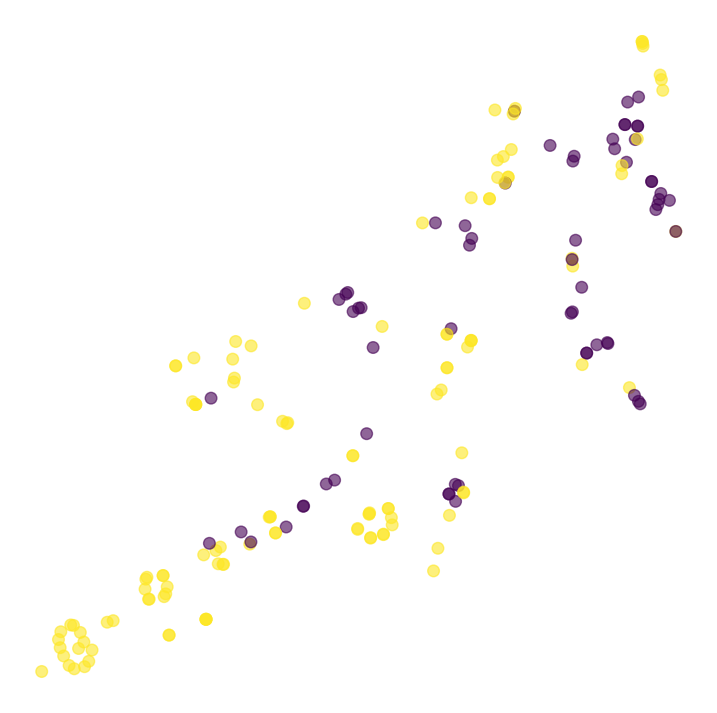

In [291]:
# TSNEを使うパターン
from sklearn.manifold import TSNE

y = [data.y.cpu() for data in dataset]

z_transformed = TSNE(n_components=2).fit_transform(graph_embeddings)
plot_points(z_transformed, y)

### 類似度を求める

In [292]:
from sklearn.metrics.pairwise import euclidean_distances

# 各グラフ間の類似度(ユークリッド距離)を求める
euc_dist = euclidean_distances(graph_embeddings)

In [302]:
# 指定したグラフの類似度ランキングを求める
import numpy as np

def get_similar_ranking(graph_index, euc_dist):
    # 指定したグラフの距離を取得
    distances = euc_dist[graph_index]
    
    # 自分自身を除外するために距離を無限大に設定
    distances[graph_index] = np.inf
    
    # 距離が小さい順にソートし、インデックスを取得
    return np.argsort(distances)

# 指定したグラフのインデックス
specified_graph_index = 0

ranking = get_similar_ranking(specified_graph_index, euc_dist)

print("Top 5 similar graphs to graph index", specified_graph_index, ":", ranking[:5])

Top 5 similar graphs to graph index 0 : [ 43  47  36   9 122]


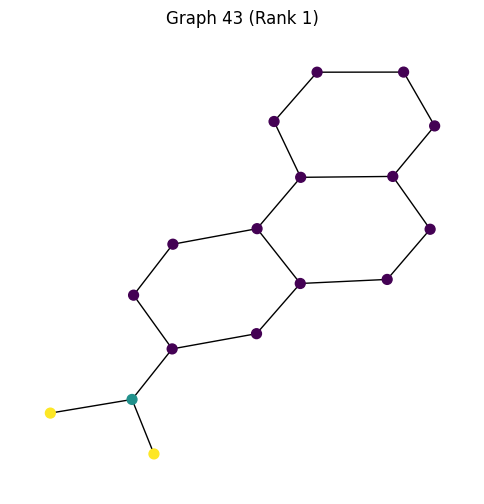

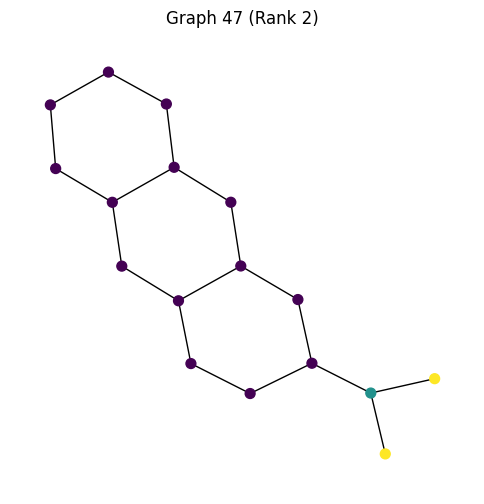

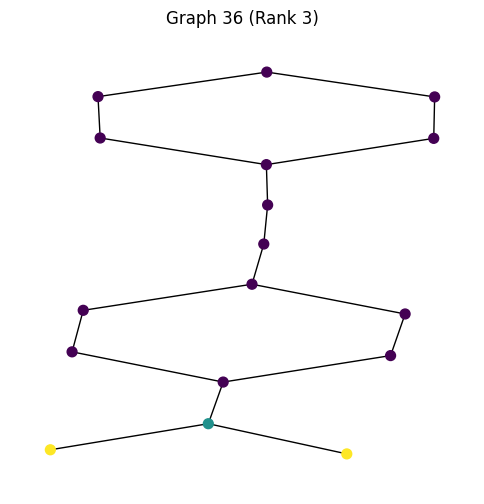

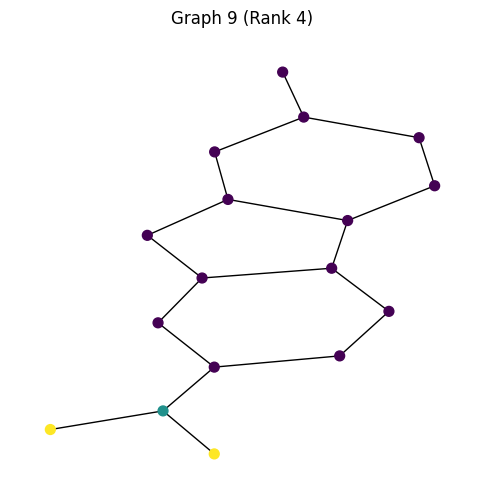

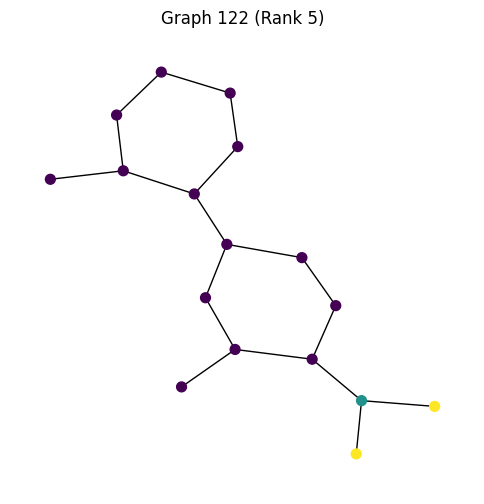

In [303]:
# 類似度トップのグラフを描画

def draw_graphs(graph_indices, dataset):
    for i, graph_idx in enumerate(graph_indices):
        G = torch_geometric.utils.convert.to_networkx(dataset[graph_idx], to_undirected=True)

        # ノードの特徴量（one-hotベクトル）
        node_features = dataset[graph_idx].x.cpu().numpy()

        # 各ノードの色をone-hotベクトルの最大値に基づいて設定
        node_colors = np.argmax(node_features, axis=1)

        cmap = plt.get_cmap('viridis', 7)  # 7次元に対応するカラーマップ


        # グラフ描画
        plt.figure(figsize=(6, 6))
        plt.title(f'Graph {graph_idx} (Rank {i + 1})')
        nx.draw(G, pos=nx.nx_pydot.graphviz_layout(G), with_labels=False, font_family="MS Gothic", node_size=50, font_size=9,
        node_color=node_colors, cmap=cmap)
        plt.show()

# 例として、類似度が高いグラフのインデックスを用意
top_k_graph_indices = ranking[:5]

# 描画
draw_graphs(top_k_graph_indices, dataset)

In [298]:
# 類似度
for i in top_k_graph_indices:
	print(euc_dist[specified_graph_index][i])

21.887577
12.797121
12.704821
24.204132
20.524586
6.7950997
21.02528
20.632061
11.635207
21.842257
22.118355
21.228254
17.777838
12.025448
24.191385
17.980064
10.673696
19.521784
12.613178
19.40474


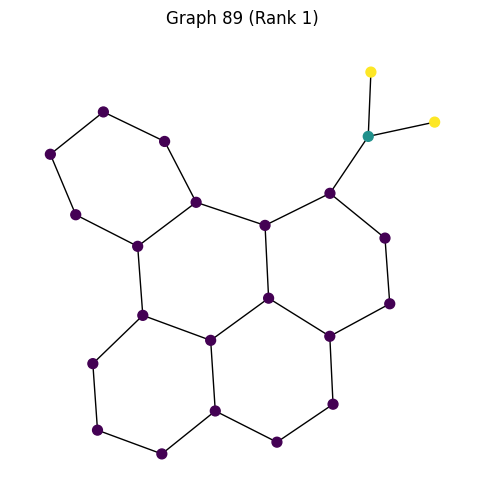

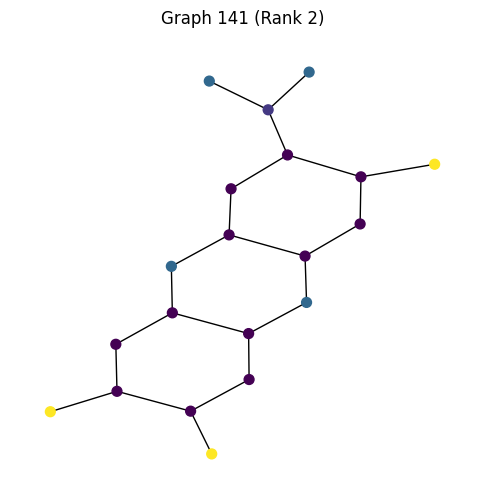

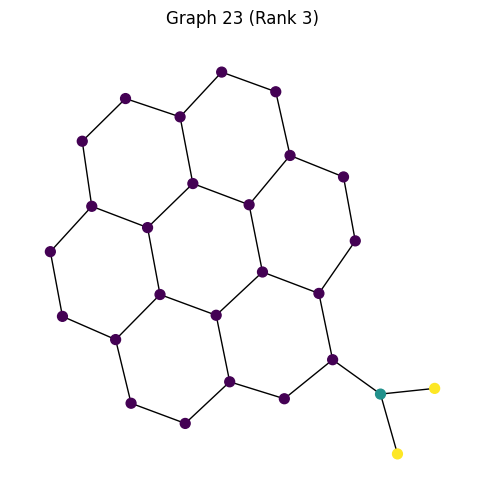

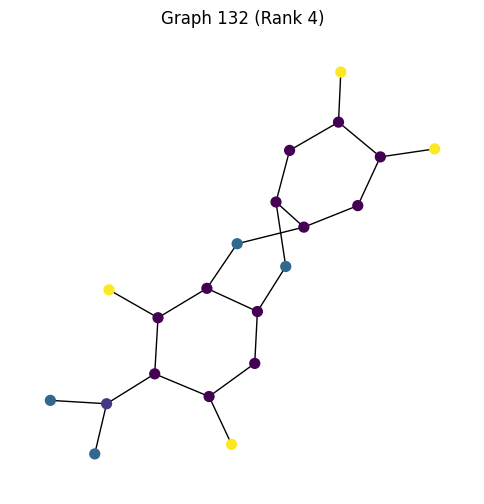

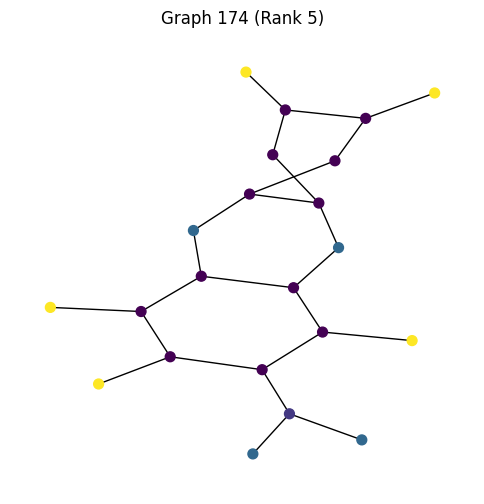

In [296]:
# 類似度ワーストのグラフを描画

top_k_graph_indices = ranking[-6:-1]

# 描画
draw_graphs(top_k_graph_indices, dataset)

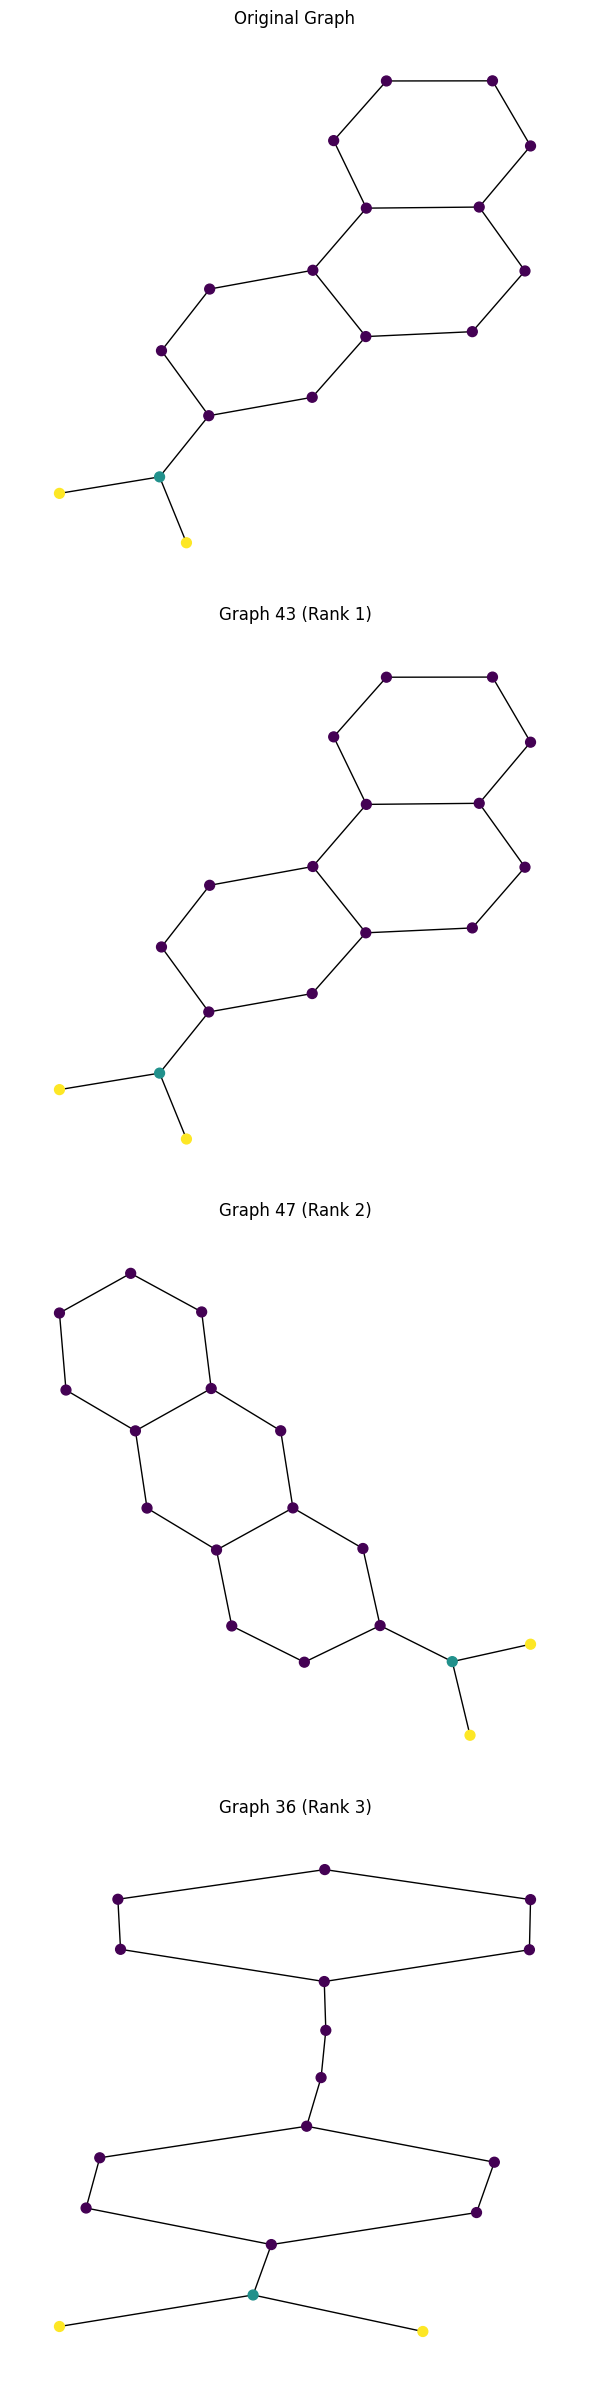

In [319]:
# 類似度ランキングを見やすく描画
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def draw_graphs(original_graph_idx, top_k_graph_indices, dataset):
    # グラフ数に応じたサブプロットの行数
    num_graphs = len(top_k_graph_indices) + 1  # 元のグラフ + ランキングされたグラフ
    fig, axs = plt.subplots(num_graphs, 1, figsize=(6, 6 * num_graphs))  # 各グラフが縦に並ぶように設定

    # 元のグラフを描画
    G_original = torch_geometric.utils.convert.to_networkx(dataset[original_graph_idx], to_undirected=True)
    node_features_original = dataset[original_graph_idx].x.cpu().numpy()
    node_colors_original = np.argmax(node_features_original, axis=1)
    cmap = plt.get_cmap('viridis', 7)
    
    axs[0].set_title(f'Original Graph')
    nx.draw(G_original, pos=nx.nx_pydot.graphviz_layout(G_original), with_labels=False, font_family="MS Gothic", 
            node_size=50, font_size=9, node_color=node_colors_original, cmap=cmap, ax=axs[0])

    # 類似度トップのグラフを描画
    for i, graph_idx in enumerate(top_k_graph_indices):
        G = torch_geometric.utils.convert.to_networkx(dataset[graph_idx], to_undirected=True)
        node_features = dataset[graph_idx].x.cpu().numpy()
        node_colors = np.argmax(node_features, axis=1)

        axs[i + 1].set_title(f'Graph {graph_idx} (Rank {i + 1})')
        nx.draw(G, pos=nx.nx_pydot.graphviz_layout(G), with_labels=False, font_family="MS Gothic", 
                node_size=50, font_size=9, node_color=node_colors, cmap=cmap, ax=axs[i + 1])

    plt.tight_layout()
    plt.show()

original_graph_idx = 0

ranking = get_similar_ranking(original_graph_idx, euc_dist)

# 例として、元のグラフと類似度が高いグラフのインデックスを用意
top_k_graph_indices = ranking[:3]  # 類似度が高いトップ5グラフのインデックス

# 描画
draw_graphs(original_graph_idx, top_k_graph_indices, dataset)
